In [2]:
import sys
!{sys.executable} -m pip install json_stream
import numpy as np
import pandas as pd
import json_stream
import json

Defaulting to user installation because normal site-packages is not writeable


In [43]:
with open("dawn-event-data.json") as f:
    data = json.load(f)
    print(len(data))
    print("DONE!")

11058699
DONE!


In [256]:
# Get player pos
def player_data(id):
  pos = [x for x in data if x['userId'] == id]
  return pos

def get_pos(d):
  pos = [x['position'] for x in d]
  x = [pos[0] for pos in pos]
  y = [pos[1] for pos in pos]
  z = [pos[2] for pos in pos]
  return x,y,z

def close_enough(pos1, pos2):
  dist = ((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2 + (pos1[2] - pos2[2])**2)**0.5
  return (dist <= 5, dist)

def get_players_near_pos(d, pos):
  return [(event['userId'], close_enough(event['position'], pos)[1]) for event in d if close_enough(event['position'], pos)[0]]

def get_event(d, event):
  events = [x for x in d if event in x['events']]
  return events

def get_unique_times(d):
  times = list(set([x['time'] for x in d]))
  return times

In [77]:
import matplotlib.pyplot as plt
import numpy as np

In [88]:
def plot_players_and_events(players, event):
  fig = plt.figure()
  ax = plt.axes(projection ='3d')

  for i in players:
    color = (np.random.random(), np.random.random(), np.random.random())
    player = player_data(i)
    events = get_event(player, event)
    x,y,z = get_pos(player)
    ex, ey, ez = get_pos(events)
    ax.scatter(ex, ey, ez, marker="o", label=f'Player {i}, {event}', color=color)
    ax.plot3D(x, y, z, label=f'Player {i}', color=color)
    ax.scatter(x[0],y[0],z[0], marker="x", label=f'Player {i} start', color=color)

  ax.legend()
  ax.set_xlabel('x-axis')
  ax.set_ylabel('y-axis')
  ax.set_zlabel('z-axis')
  ax.set_title('Plot of position and position of events')
  plt.show()


In [258]:
# Stratisfy the data by every 100 events and search within to check for any hand holding and any nearby players
step = 100
idx = 0

interactions = []
interaction_with_dists = []

while idx < len(data):
  # Get all events during this chunk of time
  events = data[idx:idx + step]
  hand_hold_event = [(event['userId'], event['position']) for event in events if "hand_held" in event["events"]]
  if hand_hold_event:
    people = get_players_near_pos(events, hand_hold_event[0][1])
    if len(people) > 1:
      interactions.append([x[0] for x in people])
      interaction_with_dists.append(people)

  idx += step

# The list of groups of handholders
interactions


[[246, 253, 227, 253, 259, 262],
 [445, 447, 442],
 [498, 502],
 [415, 506],
 [286, 514, 515],
 [529, 518, 530],
 [19, 178],
 [544, 546],
 [513, 328],
 [88, 159, 159],
 [583, 109],
 [607, 609],
 [410, 419, 420],
 [671, 672],
 [663, 600],
 [528, 377],
 [707, 630, 708, 709],
 [701, 710],
 [564, 565],
 [565, 745],
 [329, 109],
 [357, 304],
 [565, 604],
 [759, 702],
 [780, 781],
 [784, 783, 779],
 [631, 700],
 [345, 82, 527],
 [511, 515, 357],
 [821, 822, 823],
 [826, 75],
 [320, 501],
 [473, 345],
 [845, 847],
 [139, 139],
 [945, 946],
 [947, 953],
 [712, 694],
 [704, 728],
 [669, 995, 840, 945, 994, 993],
 [701, 695],
 [1024, 945, 949],
 [780, 527],
 [63, 34],
 [1056, 1058, 1036, 1057],
 [1060, 1059, 1061, 1062],
 [1061, 1070],
 [604, 347],
 [693, 689],
 [781, 784],
 [1089, 1090],
 [1090, 1092],
 [1105, 1105],
 [63, 34],
 [765, 600],
 [1129, 1130, 1131, 1132],
 [1141, 1143, 1144],
 [1152, 1153, 1119],
 [807, 762],
 [1157, 1143, 1130],
 [1172, 1143, 1173],
 [795, 851, 926],
 [306, 1176, 1

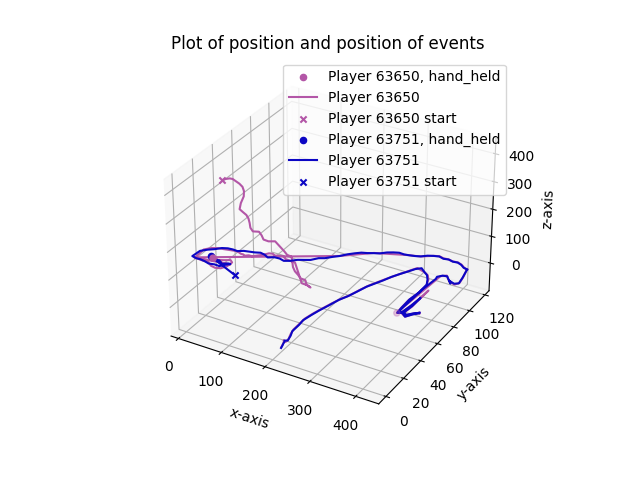

In [146]:
# Plot a pair of handholders to see their path
%matplotlib widget
plot_players_and_events([63650, 63751], "hand_held")

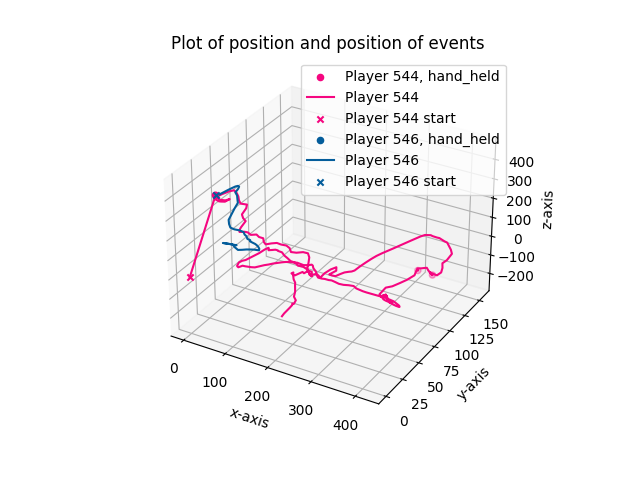

In [213]:
%matplotlib widget
plot_players_and_events([544, 546], "hand_held")

In [175]:
def get_player_interactions(player):
  return [x for x in interactions if player in x]

def get_timeframe_of_interaction(interaction):
  idx = interactions.index(interaction)
  first = idx * 100
  last = first + 100
  return data[first]['time'], data[last]['time']


In [182]:
get_timeframe_of_interaction(get_player_interactions(544)[0])

(1664339230011, 1664339231033)

In [294]:
# Out of the people who bought a candle within the timeframe of the dataset, did they make any interactions?

players_purchasing = set([x['userId'] for x in data if 'candle_purchased' in x['events']])

num_inter = 0
player_purchasing_interactions = []
for player in players_purchasing:
  inter = get_player_interactions(player)
  if inter:
    print(player, inter)
    player_purchasing_interactions.append(inter)
    num_inter += 1

20995 [[19715, 20995, 21005]]
2054 [[2054, 2055]]
33300 [[33297, 33300], [33300, 33309]]
51732 [[51732, 51702, 51731], [51732, 51729, 51730]]
17945 [[17945, 18008], [17945, 17399]]
3627 [[3627, 432, 3628], [3628, 3627]]
12336 [[12381, 12336, 12385, 12384, 12386]]
3121 [[3121, 23494, 5401]]
1591 [[1589, 1591, 1798], [1591, 1589], [1798, 1591, 1589]]
34359 [[34359, 35055]]
24127 [[24127, 33560], [24127, 33545], [33624, 24127], [24127, 34909]]
32834 [[32944, 32834]]
43587 [[44589, 43587]]
583 [[583, 109]]
590 [[379, 590]]
80 [[26552, 80]]
12398 [[12398, 12340, 12401]]
33907 [[33909, 33907], [33907, 33891, 33867, 33910, 33909, 33912]]
30845 [[29900, 30845]]
52870 [[52870, 42374, 52871, 52753]]
36491 [[36491, 36492]]
3216 [[3213, 3216, 3910]]
40589 [[40587, 40589, 40585], [6134, 40589], [44589, 56361, 40589, 40585, 54962], [40589, 63923]]
15516 [[15627, 15516], [14951, 16125, 15516, 16102], [16762, 16223, 15516]]
38048 [[38048, 16916]]
34978 [[34978, 32935, 34977, 34980]]
41637 [[41637, 485

In [295]:
max(player_purchasing_interactions, key=len)

[[32901, 32934, 32935, 32936],
 [32895, 32941, 32935],
 [33029, 32935],
 [267, 32935, 32934],
 [33805, 32935],
 [33624, 32935],
 [33871, 33872, 32935],
 [34218, 34219, 34220, 32935],
 [32935, 34239],
 [34978, 32935, 34977, 34980],
 [35072, 32935],
 [1527, 32935],
 [35340, 35373, 32935, 35193],
 [35651, 32935, 17305],
 [35924, 32935],
 [36482, 36549, 32935, 36550]]

In [225]:
print("# of people who bought candle and made interactions:", num_inter)
print("# of people who bought candle but made no interactions:", len(players_purchasing) - num_inter)

# of people who bought candle and made interactions: 63
# of people who bought candle but made no interactions: 127


In [274]:

from itertools import combinations
def network_interaction_of_player(player):
  G = nx.Graph()
  # Plotting first five interactions
  inters = get_player_interactions(player)
  print(inters)
  for interaction in inters:
    combs = list(combinations(interaction, 2))
    G.add_edges_from(combs)

  fig = plt.figure()
  ax = plt.axes()
  ax.set_title(f"Interactions graph of Player #{player}")
  nx.draw(G, node_size=0, alpha=0.4, edge_color="r", font_size=16, with_labels=True)
  

[[39665, 39753, 36851], [57075, 47342, 15438, 36851, 57014]]


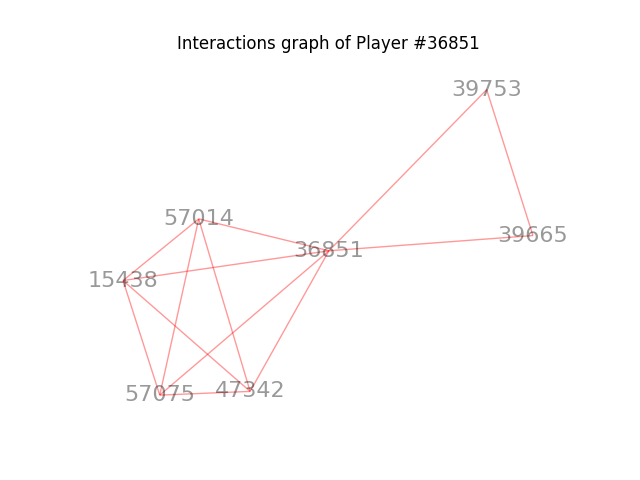

In [275]:
network_interaction_of_player(36851)

[[40587, 40589, 40585], [6134, 40589], [44589, 56361, 40589, 40585, 54962], [40589, 63923]]


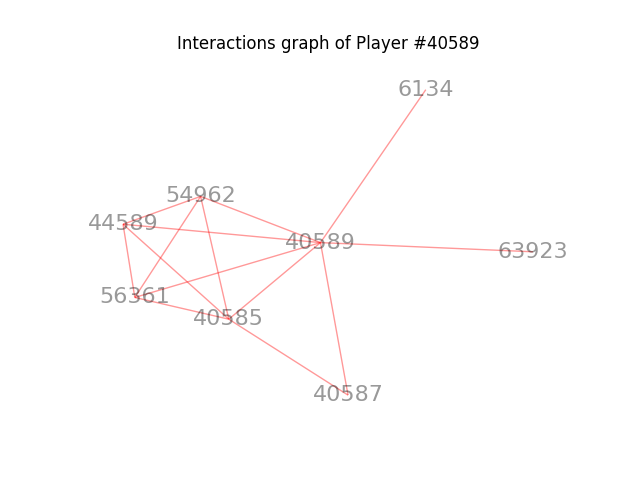

In [276]:
network_interaction_of_player(40589)

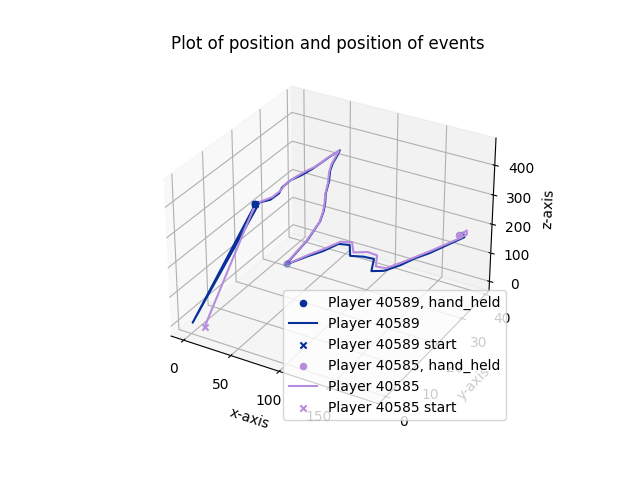

In [277]:
# Beautiful couple <3
plot_players_and_events([40589, 40585], "hand_held")

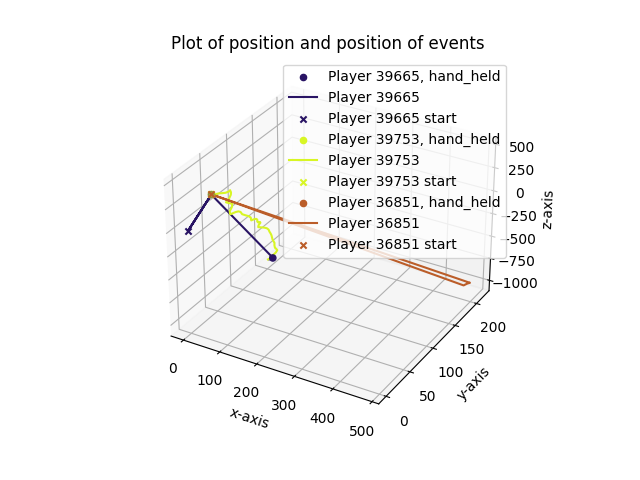

In [309]:
plot_players_and_events([39665, 39753, 36851], "hand_held")

In [ ]:
plot_players_and_events([3604], "hand_held")

## Interesting finds:

[[32901, 32934, 32935, 32936], [32895, 32941, 32935], [33029, 32935], [267, 32935, 32934], [33805, 32935], [33624, 32935], [33871, 33872, 32935], [34218, 34219, 34220, 32935], [32935, 34239], [34978, 32935, 34977, 34980], [35072, 32935], [1527, 32935], [35340, 35373, 32935, 35193], [35651, 32935, 17305], [35924, 32935], [36482, 36549, 32935, 36550]]


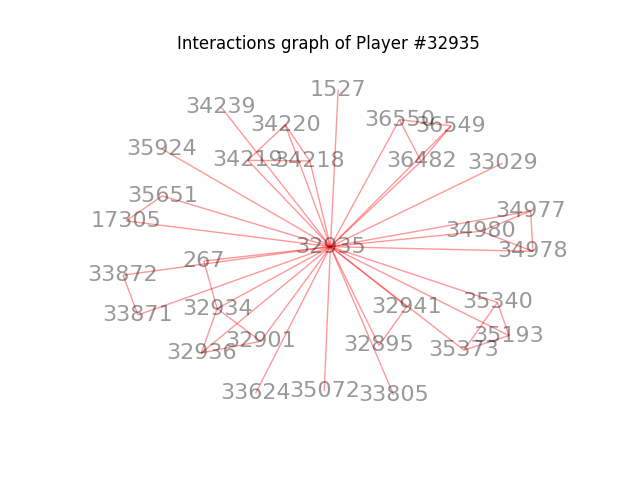

In [296]:
# Sus? So many connections
network_interaction_of_player(32935)

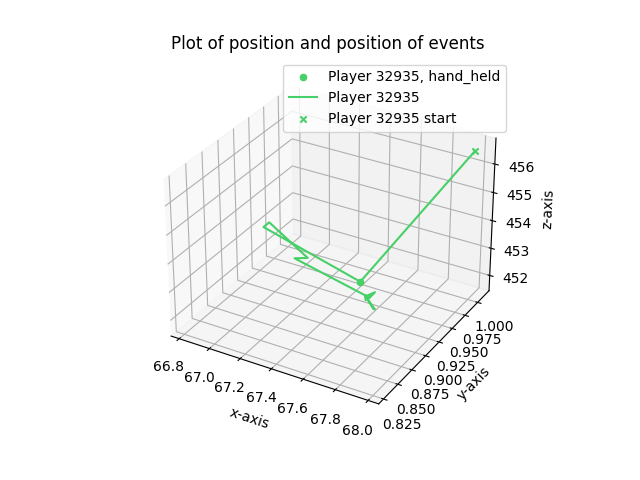

In [303]:
plot_players_and_events([32935], "hand_held")

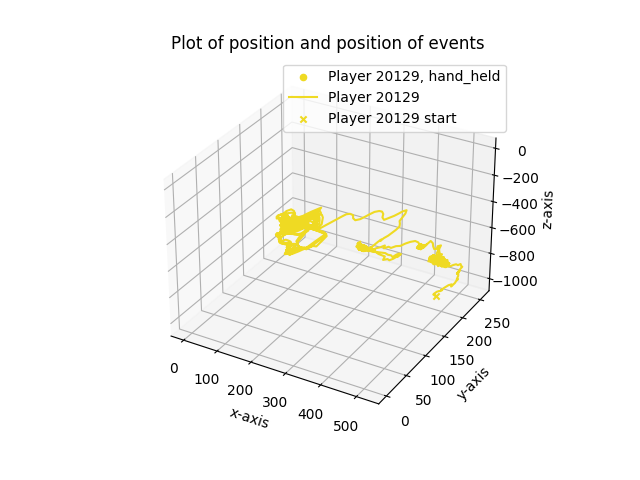

In [302]:
# Suspicious movement? A lot of looping
plot_players_and_events([20129], "hand_held")

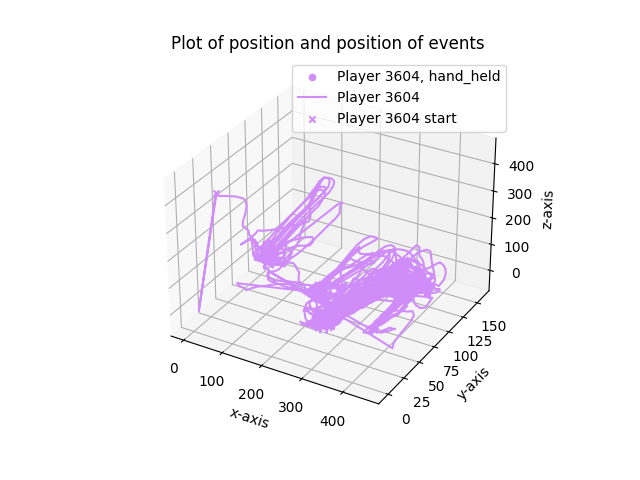

In [301]:
# Sus
plot_players_and_events([3604], "hand_held")

[[3604, 3605, 3576, 3560, 3606], [5512, 5505, 3604]]


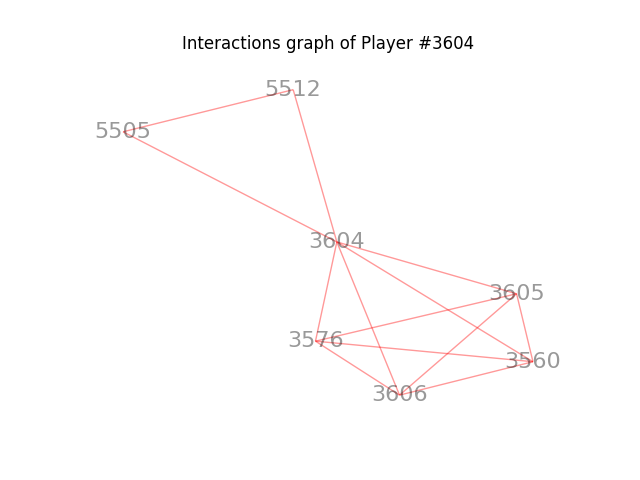

In [305]:
network_interaction_of_player(3604)
# Didn't initiate any of the hand holding, but interacted (hand held) by others